In [8]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt
#https://github.com/Auquan/Tutorials/blob/master/Pairs%20Trading.ipynb

In [9]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


In [12]:

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2018/01/01'
endDateStr = '2019/12/12'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['sig.ax','pme.ax','myx.ax','fph.ax',
                 'csl.ax','coh.ax','api.ax','ann.ax']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: sig.ax
Processing data for stock: pme.ax
Processing data for stock: myx.ax
Processing data for stock: fph.ax
Processing data for stock: csl.ax
Processing data for stock: coh.ax
Processing data for stock: api.ax
Processing data for stock: ann.ax
20% done...
40% done...
60% done...
80% done...


In [13]:
data.tail(4)

,sig.ax,pme.ax,myx.ax,fph.ax,csl.ax,coh.ax,api.ax,ann.ax
2019-09-26,0.610,28.629999,0.48,15.700000,233.839996,204.800003,1.36,27.500000
2019-09-27,0.595,28.000000,0.50,15.730000,234.300003,207.369995,1.36,27.600000
2019-09-30,0.600,27.820000,0.52,16.049999,233.690002,208.149994,1.35,27.410000
2019-10-01,0.615,29.330000,0.53,16.290001,238.399994,213.500000,1.40,27.719999


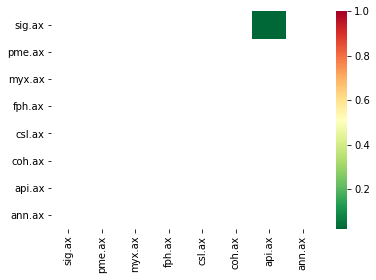

[('sig.ax', 'api.ax')]


In [14]:

# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
#m = [0,0.2,0.4,0.6,0.8,1]
m = np.linspace(0,1,6)
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
plt.show()
print(pairs)

P-Value                        :  0.24824
T-stat score for co-integration:  -2.57207


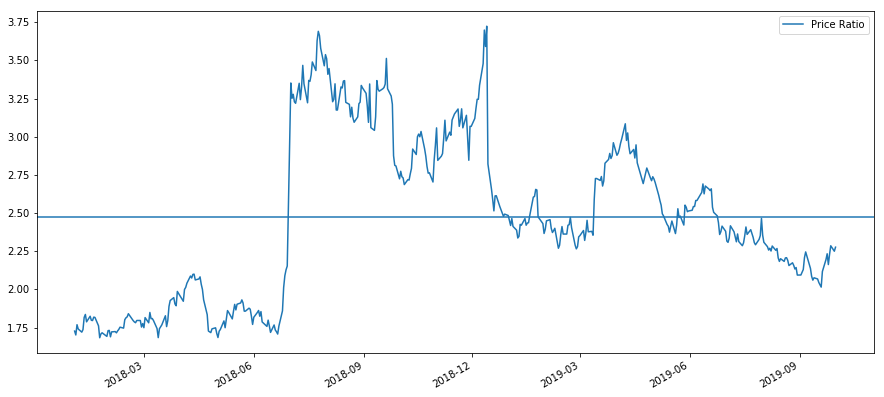

In [15]:
S1 = data['api.ax']
S2 = data['sig.ax']
score, pvalue, _ = coint(S1, S2)
print('P-Value                        : ',pvalue.round(5))
print("T-stat score for co-integration: ",score.round(5))
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [16]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

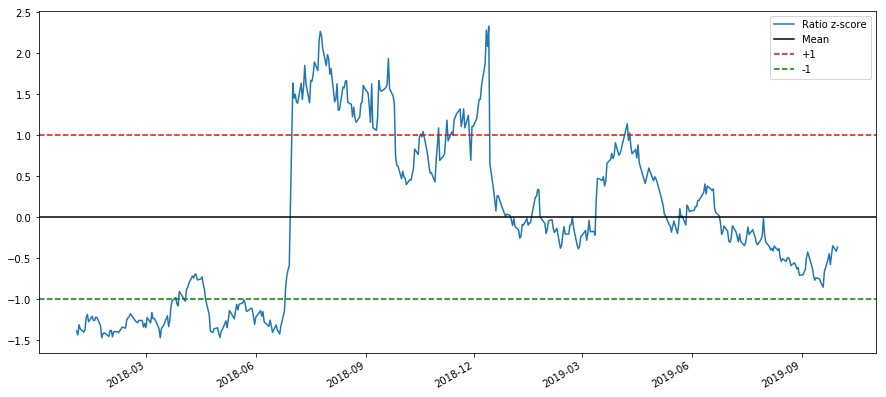

In [17]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [18]:
ratios = S1 / S2
print(len(ratios))
train = ratios[:504]
test = ratios[504:]

442


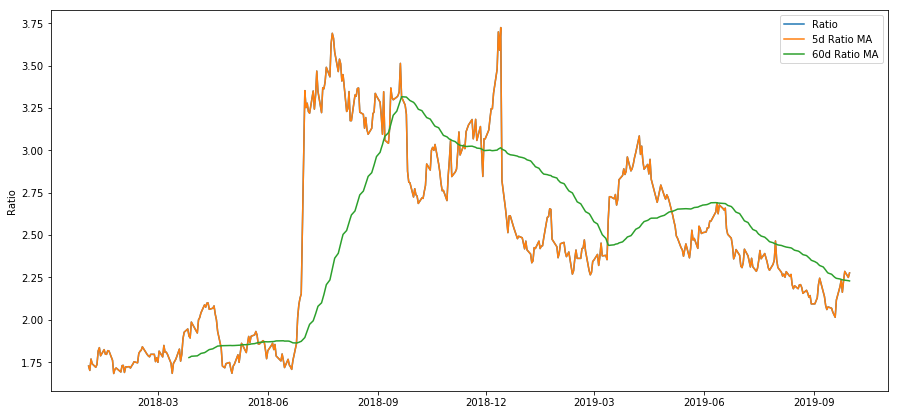

In [19]:
ratios_mavg5 = train.rolling(window=1,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

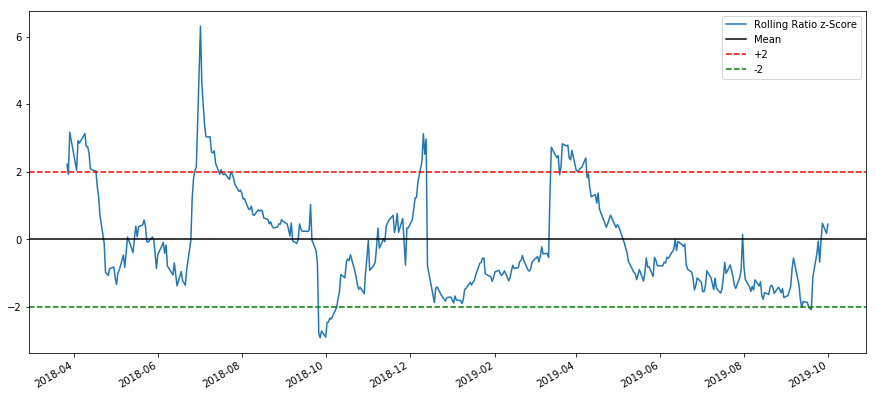

In [20]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])
plt.show()


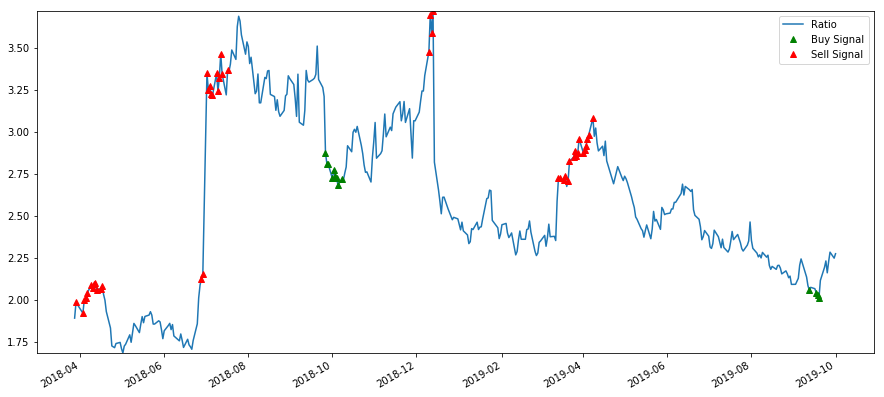

In [21]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-2] = 0
sell[zscore_60_5<2] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

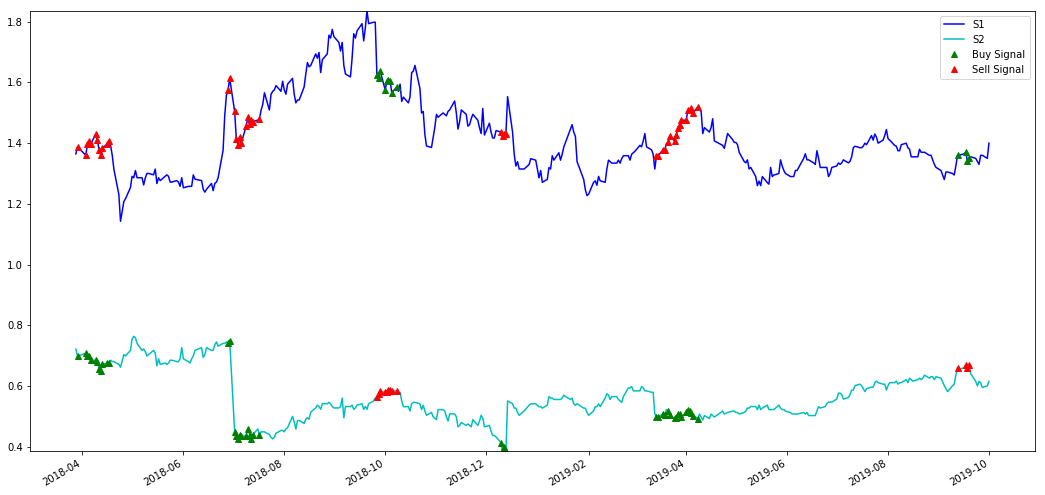

In [22]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
#S1 = data['BSX'].iloc[:504]
#S2 = data['AGN'].iloc[:504]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['S1','S2', 'Buy Signal', 'Sell Signal'])
plt.show()

In [23]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 2.0:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -2.0:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.1 and .1
        elif abs(zscore[i]) < 0.1:
            money += countS1*S1[i] - S2[i] * countS2
            count = 0
            
    return money
td = trade(S1.iloc[:504], S2.iloc[:504], 60, 5)
print(td)

350.23547043060495
